# SV Data Analysis

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os, sys
sys.path.insert(0, '/Users/jocelynornelasmunoz/Desktop/structural_variants/lib')
sys.path.insert(0, '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/structural_variants/lib')
DATA_PATH='/Users/jocelynornelasmunoz/Desktop/structural_variants/data/simulated/4p_4c_coverage'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import metrics
import confusion_matrix as confmat

# Define function to plot ROC curves

In [9]:
def compute_FPR_TPR(path, suffix = None,save=False):
    data = json.loads(open(path).read())
    fhat_SPIRAL = np.array(data['fhat_SPIRAL'])
    fhat_NEBULA = np.array(data['fhat_NEBULA'])
    f_true = np.array(data['f_true'])
    d={}
    d['fpr_SPIRAL'], d['tpr_SPIRAL'], d['thresholds_SPIRAL'] = metrics.roc_curve(f_true, fhat_SPIRAL, pos_label=1)
    d['fpr_NEBULA'], d['tpr_NEBULA'], d['thresholds_NEBULA'] = metrics.roc_curve(f_true, fhat_NEBULA, pos_label=1)
    d['roc_auc_SPIRAL'] = metrics.auc(d['fpr_SPIRAL'], d['tpr_SPIRAL'])
    d['roc_auc_NEBULA'] = metrics.auc(d['fpr_NEBULA'], d['tpr_NEBULA'])
    
    return d
def plot_ROC(params, title=None, save=False):    
    display_SPIRAL = metrics.RocCurveDisplay(fpr=params['fpr_SPIRAL'], tpr=params['tpr_SPIRAL'], roc_auc=params['roc_auc_SPIRAL'], estimator_name='SPIRAL')
    display_NEBULA = metrics.RocCurveDisplay(fpr=params['fpr_NEBULA'], tpr=params['tpr_NEBULA'], roc_auc=params['roc_auc_NEBULA'], estimator_name='NEBULA')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    if title is not None: fig.suptitle(title, fontsize=20)
    display_SPIRAL.plot(ax=ax1)
    display_NEBULA.plot(ax=ax2)
    if save: plt.savefig('%s.png'%title, format='png')
    plt.show()

# Plot results

In [10]:
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/structural_variants/'
desktop_path = '/Users/jocelynornelasmunoz/Desktop/structural_variants/'

In [12]:
data = json.loads(open(laptop_path+'0.10tau_5.00gamma_700it.json').read())

In [13]:
fhat_SPIRAL = np.array(data['fhat_SPIRAL'])
fhat_NEBULA = np.array(data['fhat_NEBULA'])
f_true = np.array(data['f_true'])

In [17]:
z_PS = fhat_SPIRAL[:100]
z_HS = fhat_SPIRAL[100+1:200]
z_NS = fhat_SPIRAL[200+1:300]
y_PS = fhat_SPIRAL[300+1:400]
y_HS = fhat_SPIRAL[400+1:500]
y_NS = fhat_SPIRAL[500+1:600]
z_PN = fhat_NEBULA[:100]
z_HN = fhat_NEBULA[100+1:200]
z_NN = fhat_NEBULA[200+1:300]
y_PN = fhat_NEBULA[300+1:400]
y_HN = fhat_NEBULA[400+1:500]
y_NN = fhat_NEBULA[500+1:600]

In [21]:
d={}
d['fpr_SPIRAL'], d['tpr_SPIRAL'], d['thresholds_SPIRAL'] = metrics.roc_curve(f_true[101:200], z_HS, pos_label=1)
d['fpr_NEBULA'], d['tpr_NEBULA'], d['thresholds_NEBULA'] = metrics.roc_curve(f_true[101:200], z_HN, pos_label=1)
d['roc_auc_SPIRAL'] = metrics.auc(d['fpr_SPIRAL'], d['tpr_SPIRAL'])
d['roc_auc_NEBULA'] = metrics.auc(d['fpr_NEBULA'], d['tpr_NEBULA'])

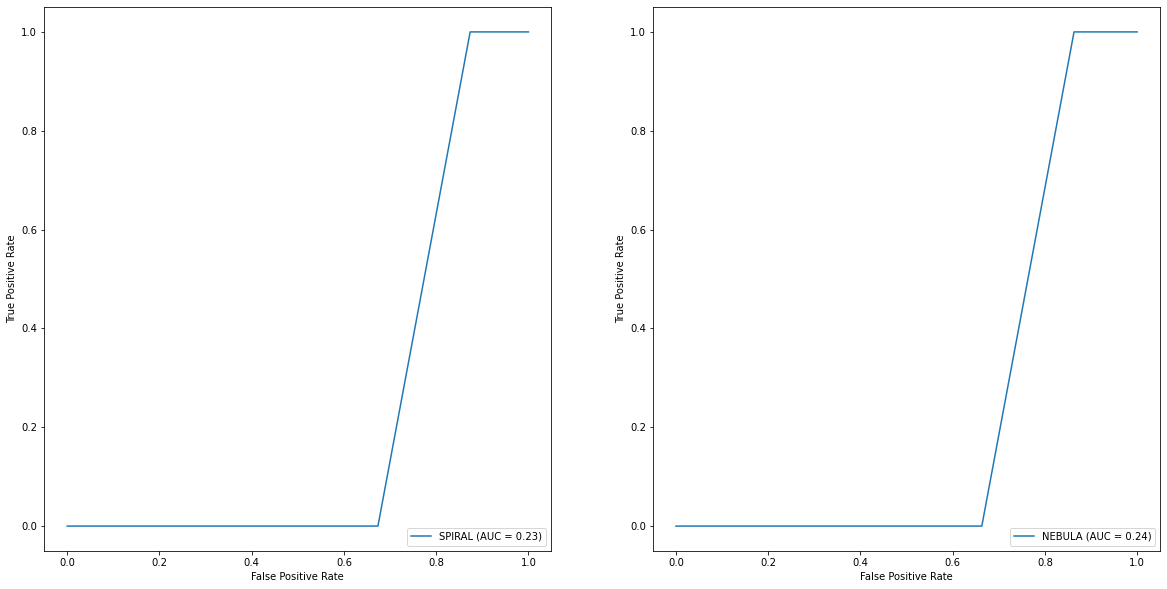

In [22]:
plot_ROC(d)

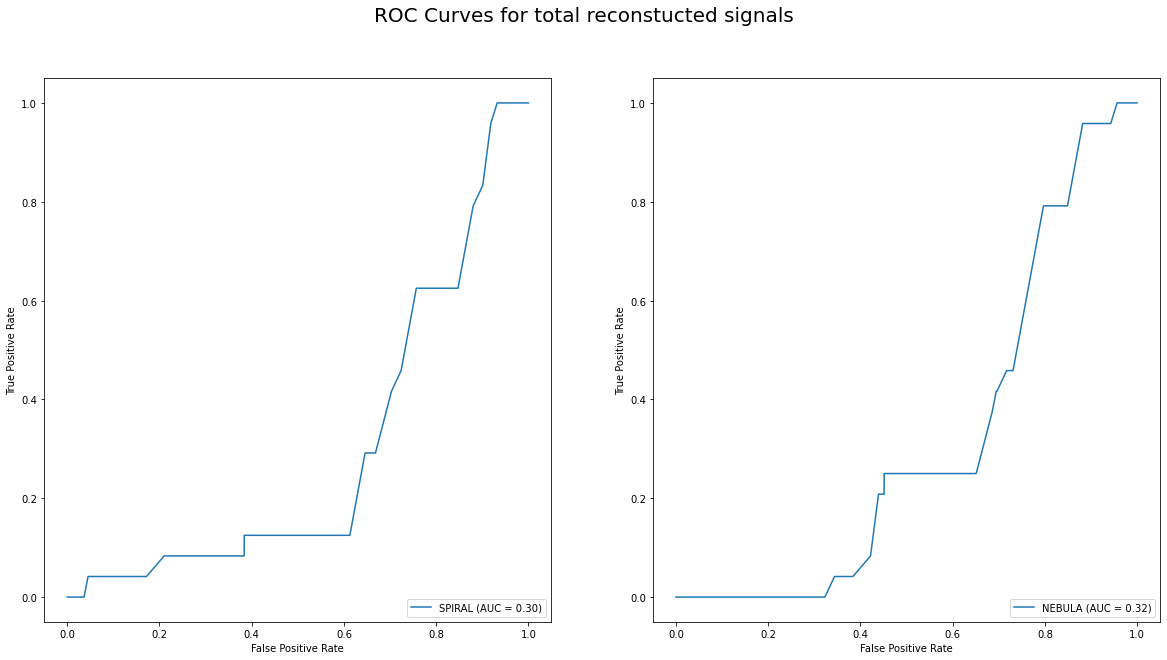

In [115]:
FPTP = compute_FPR_TPR(desktop_path+'0.10tau_5.00gamma_700it.json')
roc_plot = plot_ROC(FPTP, title='ROC Curves for total reconstucted signals',save=True)

In [119]:
np.nonzero(data['fhat_SPIRAL'])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [118]:
np.count_nonzero(data['fhat_NEBULA'])

600

(array([ 24.,   3.,   9., 320.,  24.,  40.,  39.,  77.,  33.,  31.]),
 array([-0.32355838, -0.2344629 , -0.14536741, -0.05627193,  0.03282355,
         0.12191903,  0.21101451,  0.30010999,  0.38920547,  0.47830095,
         0.56739644]),
 <BarContainer object of 10 artists>)

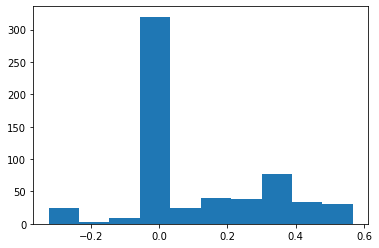

In [121]:
plt.hist(data['fhat_SPIRAL'])

In [126]:
(np.array(data['fhat_SPIRAL']) > 0.5).astype('int')

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [127]:
(np.array(data['f_true']) > 0.5).astype('int')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,